In [ ]:
using CSV, DataFrames, GLM, RegressionTables, Statistics, PrettyTables, Effects, LinearAlgebra, CairoMakie, Gadfly


function scale(df::DataFrame; cols::Vector{String} = names(df))
    result = copy(df)
    for col in cols
        result[!, col] = (df[!, col] .- mean(df[!, col])) ./ std(df[!, col])
    end
    return result
end

function scale(x::AbstractVector)
    return (x .- mean(x)) ./ std(x)
end

function scalem(x::AbstractVector)
    return (skipmissing(x) .- mean(skipmissing(x))) ./ std(skipmissing(x))
end

function model_to_df(model)
    return DataFrame(
        coef_name=GLM.coefnames(model),
        coef=GLM.coef(model),
        std_error=GLM.stderror(model),
        t=GLM.coeftable(model).cols[3],
        pr=GLM.coeftable(model).cols[4],
        lower=GLM.confint(model)[:,1],
        upper=GLM.confint(model)[:,2],
    )
end
;

In [2]:
"""
conditional_coef_link(m, x1::Symbol, x2::Symbol, cvals; level=0.95)

Compute the conditional coefficient of `x1` at values of `x2` = `cvals` on the *link scale*
for a GLM/LM `m` that includes the interaction `x1 & x2`.
Returns a DataFrame with estimate, SE, and confidence interval.

This method is developed with the aid of chatGPT.
"""
function conditional_coef_link(m, x1::Symbol, x2::Symbol, cvals; level=0.95)
    names = coefnames(m)
    # find indices for main and interaction terms
    ix1 = findfirst(==(String(x1)), names)
    iint = findfirst(n -> occursin(String(x1), n) && occursin(String(x2), n), names)
    isnothing(ix1)  && error("Couldn't find coefficient for $x1")
    isnothing(iint) && error("Couldn't find interaction coefficient for $x1:$x2")

    β   = coef(m)
    V   = vcov(m)
    α   = 1 - level
    z   = quantile(Normal(), 1 - α/2)

    result = DataFrame(x2_value = Float64[], estimate = Float64[],
                    se = Float64[], lower = Float64[], upper = Float64[])

    for c in cvals
        est = β[ix1] + c * β[iint]
        var = V[ix1, ix1] + c^2 * V[iint, iint] + 2c * V[ix1, iint]
        se  = sqrt(var)
        push!(result, (c, est, se, est - z*se, est + z*se))
    end
    result
end
;

In [3]:
output = "../output/regression"
;

In [4]:
# bp=CSV.read("../src/regression/budapest/bp_socioecon_merged5.csv", DataFrame)
bp=CSV.read("../output/budapest/20250428/indicators_with_ses.csv", DataFrame)

# madrid=CSV.read("../src/regression/madrid/madrid_socioecon_merged2.csv", DataFrame)
# madrid=CSV.read("../output/madrid/socioecon_merged2.csv", DataFrame)
# helsinki=CSV.read("../src/regression/helsinki/helsinki_socioecon_merged4.csv", DataFrame)
madrid=CSV.read("../output/madrid/20250415/indicators_with_ses.csv", DataFrame)
# helsinki=CSV.read("../output/helsinki/socioecon_merged4.csv", DataFrame)
helsinki=CSV.read("../output/helsinki/20250428/indicators_with_ses.csv", DataFrame)
;

In [5]:
bp.mean_price = bp.walk15_mean_price;

In [6]:
dropmissing!(helsinki, [:weighted_gini_walk, :weighted_gini_multi, :weighted_med_inc_walk, :weighted_med_inc_multi]);
dropmissing!(madrid, [:weighted_gini_walk, :weighted_gini_multi, :weighted_net_income_hh_walk, :weighted_net_income_hh_multi]);

In [7]:
cols=[
    "cultural_institutions_multimodal",
    "drugstores_multimodal",
    "groceries_multimodal",
    "healthcare_multimodal",
    "parks_multimodal",
    "religious_organizations_multimodal",
    "restaurants_multimodal",
    "schools_multimodal",
    "services_multimodal",
    "cultural_institutions_walk15",
    "drugstores_walk15",
    "groceries_walk15",
    "healthcare_walk15",
    "parks_walk15",
    "religious_organizations_walk15",
    "restaurants_walk15",
    "schools_walk15",
    "services_walk15",
];


In [8]:
is_there_amenity(x) = x > 0 ? 1 : 0
bp = bp[!, cols] .= is_there_amenity.(bp[!, cols])
madrid = madrid[!, cols] .= is_there_amenity.(madrid[!, cols])
helsinki = helsinki[!, cols] .= is_there_amenity.(helsinki[!, cols])
;

In [9]:
bp.walk_sum =
    bp.cultural_institutions_walk15 .+ bp.drugstores_walk15 .+ bp.groceries_walk15 .+
    bp.healthcare_walk15 .+ bp.parks_walk15 .+ bp.religious_organizations_walk15 .+
    bp.restaurants_walk15 .+ bp.schools_walk15 .+ bp.services_walk15
;
bp.multimod_sum =
    bp.cultural_institutions_multimodal .+ bp.drugstores_multimodal .+
    bp.groceries_multimodal .+ bp.healthcare_multimodal .+ bp.parks_multimodal .+
    bp.religious_organizations_multimodal .+ bp.restaurants_multimodal .+
    bp.schools_multimodal .+ bp.services_multimodal
;
helsinki.walk_sum =
    helsinki.cultural_institutions_walk15 .+ helsinki.drugstores_walk15 .+
    helsinki.groceries_walk15 .+ helsinki.healthcare_walk15 .+ helsinki.parks_walk15 .+
    helsinki.religious_organizations_walk15 .+ helsinki.restaurants_walk15 .+
    helsinki.schools_walk15 .+ helsinki.services_walk15
;
helsinki.multimod_sum =
    helsinki.cultural_institutions_multimodal .+ helsinki.drugstores_multimodal .+
    helsinki.groceries_multimodal .+ helsinki.healthcare_multimodal .+
    helsinki.parks_multimodal .+ helsinki.religious_organizations_multimodal .+
    helsinki.restaurants_multimodal .+ helsinki.schools_multimodal .+
    helsinki.services_multimodal
;
madrid.walk_sum =
    madrid.cultural_institutions_walk15 .+ madrid.drugstores_walk15 .+
    madrid.groceries_walk15 .+ madrid.healthcare_walk15 .+ madrid.parks_walk15 .+
    madrid.religious_organizations_walk15 .+ madrid.restaurants_walk15 .+
    madrid.schools_walk15 .+ madrid.services_walk15
;
madrid.multimod_sum =
    madrid.cultural_institutions_multimodal .+ madrid.drugstores_multimodal .+
    madrid.groceries_multimodal .+ madrid.healthcare_multimodal .+ madrid.parks_multimodal .+
    madrid.religious_organizations_multimodal .+ madrid.restaurants_multimodal .+
    madrid.schools_multimodal .+ madrid.services_multimodal
;


# 2.0 Main regressions without interactions

In [10]:
bp.gini_diff_exp = bp.gini_multimodal .- bp.gini_walk15
bp.gini_diff_house = bp.gini_house_multimodal .- bp.gini_house_walk15

helsinki.gini_diff = helsinki.weighted_gini_multi .- helsinki.weighted_gini_walk
madrid.gini_diff = madrid.weighted_gini_multi .- madrid.weighted_gini_walk


bp.access_diff = bp.multimod_sum .- bp.walk_sum
madrid.access_diff = madrid.multimod_sum .- madrid.walk_sum
helsinki.access_diff = helsinki.multimod_sum .- helsinki.walk_sum
;

In [11]:
bp1_noint = lm(
    @formula(
        gini_diff_exp ~ gini_walk15 + area_difference + ellipticity + distance_betweenness
    ),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_exp ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0652655    0.00201175    32.44    <1e-99   0.0613214     0.0692097
gini_walk15           -0.308581     0.00875332   -35.25    <1e-99  -0.325742     -0.29142
area_difference        0.000389805  0.000136707    2.85    0.0044   0.000121784   0.000657826
ellipticity            0.0161486    0.00152433    10.59    <1e-25   0.0131601     0.0191371
distance_betweenness  -0.00291555   9.56348e-5   -30.49    <1e-99  -0

In [12]:
bp2_noint = lm(
    @formula(
        gini_diff_house ~
        gini_walk15 + area_difference + ellipticity + distance_betweenness
    ),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                            Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.023256    0.00484056    4.80    <1e-05   0.0137658    0.0327462
gini_walk15           -0.153854    0.0210618    -7.30    <1e-12  -0.195146    -0.112561
area_difference        0.00425741  0.000328937  12.94    <1e-36   0.00361251   0.00490231
ellipticity           -0.0025328   0.00366776   -0.69    0.4899  -0.00972364   0.00465804
distance_betweenness  -0.00151684  0.000230111  -6.59    <1e-10  -0.00196798  -0.00106569


In [13]:
helsinki1_noint = lm(
    @formula(
        gini_diff ~
        weighted_gini_walk + area_difference + ellipticity + distance_betweenness
    ),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.123479     0.00268429    46.00    <1e-99   0.118215      0.128742
weighted_gini_walk    -0.389354     0.00821286   -47.41    <1e-99  -0.405458     -0.373249
area_difference        0.000224803  4.37746e-5     5.14    <1e-06   0.000138965   0.00031064
ellipticity            0.000166602  0.000743835    0.22    0.8228  -0.00129198    0.00162518
distance_betweenness  -0.000325887  4.55637e-5    -7.15    <1e-11 

In [14]:
madrid1_noint = lm(
    @formula(
        gini_diff ~
        weighted_gini_walk + area_difference + ellipticity + distance_betweenness
    ),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.35123    0.171134     37.11    <1e-99   6.01574     6.68673
weighted_gini_walk    -0.178915   0.00470709  -38.01    <1e-99  -0.188143   -0.169687
area_difference       -0.0144015  0.0103702    -1.39    0.1650  -0.0347314   0.00592841
ellipticity           -0.222714   0.0849451    -2.62    0.0088  -0.389242   -0.0561854
distance_betweenness  -0.0809069  0.00592679  -13.65    <1e-40  -0.0925259  -0.0692879
───────────────────

In [15]:
bp1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            7.86062    0.0646169    121.65    <1e-99   7.73393     7.9873
walk_sum              -0.874969   0.00569809  -153.55    <1e-99  -0.88614    -0.863798
area_difference        0.0460352  0.00373542    12.32    <1e-33   0.0387117   0.0533587
ellipticity           -0.172796   0.042956      -4.02    <1e-04  -0.257014   -0.088579
distance_betweenness  -0.011643   0.00225808    -5.16    <1e-06  -0.0160701  -0.00721592
─────────────────────

In [16]:
helsinki1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.36057     0.10468     60.76    <1e-99   6.1553      6.56583
walk_sum              -0.747249    0.0104086  -71.79    <1e-99  -0.767659   -0.726838
area_difference        0.0851082   0.0045338   18.77    <1e-73   0.0762179   0.0939985
ellipticity            0.270824    0.0769229    3.52    0.0004   0.119987    0.421662
distance_betweenness  -0.0449762   0.0049477   -9.09    <1e-18  -0.0546781  -0.0352743
────────────────────────────────

In [17]:
madrid1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            5.10217    0.0837467    60.92    <1e-99   4.93799     5.26635
walk_sum              -0.570749   0.00815176  -70.02    <1e-99  -0.58673    -0.554768
area_difference        0.0918017  0.00510078   18.00    <1e-69   0.081802    0.101801
ellipticity            0.0950967  0.0420187     2.26    0.0237   0.0127225   0.177471
distance_betweenness  -0.0418843  0.0031428   -13.33    <1e-39  -0.0480455  -0.0357231
─────────────────────────────────

In [18]:
regtable(
    helsinki1a_noint,
    madrid1a_noint,
    bp1a_noint,
    helsinki1_noint,
    madrid1_noint,
    bp2_noint,
    bp1_noint;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    wrap_table = true,
    label = "tab:madrid_stats",
    file="$(output)/SI_Reg_1_noint.tex"
)
# label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true
regtable(
    helsinki1a_noint,
    madrid1a_noint,
    bp1a_noint,
    helsinki1_noint,
    madrid1_noint,
    bp2_noint,
    bp1_noint;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    file="$(output)/SI_Reg_1_noint.txt"
)


----------------------------------------------------------------------------------------------------------------------
                        Helsinki     Madrid     Budapest    Helsinki     Madrid                  Budapest             
                       ---------   ---------   ---------   ---------   ---------   -----------------------------------
                                     Access                         Gini           Residential Gini   Experienced Gini
                       ---------------------------------   ---------------------   ----------------   ----------------
                             (1)         (2)         (3)         (4)         (5)                (6)                (7)
----------------------------------------------------------------------------------------------------------------------
(Intercept)             6.361***    5.102***    7.861***    0.123***    6.351***           0.023***           0.065***
                         (0.105)     (0.084)   

In [19]:
# pretty_table(stdout, mad_sum, backend = Val(:latex); show_subheader=false, label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true)

In [20]:
# bp_avg_price = CSV.read("../src/regression/budapest/stop_property_price.csv", DataFrame);
# bp = leftjoin(bp, bp_avg_price, on="stop_id");

In [21]:
bp1_noint_l = lm(@formula(
  gini_diff_exp ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.arpu_low_ratio_walk15 > median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_exp ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0719832    0.00355644    20.24    <1e-82   0.0650085     0.0789578
gini_walk15           -0.305888     0.0132046    -23.17    <1e-99  -0.331784     -0.279992
area_difference        0.000113943  0.00016495     0.69    0.4898  -0.000209548   0.000437434
ellipticity            0.0173545    0.00210044     8.26    <1e-15   0.0132352     0.0214737
distance_betweenness  -0.00423509   0.000234109  -18.09    <1e-67  -

In [22]:
bp1_noint_h = lm(@formula(
  gini_diff_exp ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.arpu_low_ratio_walk15 < median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_exp ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0985342    0.00289816    34.00    <1e-99   0.0928505     0.104218
gini_walk15           -0.633155     0.0185991    -34.04    <1e-99  -0.669631     -0.59668
area_difference        0.000270092  0.000212135    1.27    0.2031  -0.000145936   0.00068612
ellipticity            0.0153963    0.00207258     7.43    <1e-12   0.0113317     0.019461
distance_betweenness  -0.0021033    0.000115001  -18.29    <1e-68  -0.00232

In [23]:
bp2_noint_l = lm(@formula(
  gini_diff_house ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                            Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0275085   0.00790418    3.48    0.0005   0.0120072    0.0430098
gini_walk15           -0.167055    0.0549016    -3.04    0.0024  -0.274725    -0.0593848
area_difference        0.00252155  0.000503394   5.01    <1e-06   0.00153432   0.00350878
ellipticity            0.0140618   0.00504561    2.79    0.0054   0.00416656   0.0239569
distance_betweenness  -0.00209403  0.000305042  -6.86    <1e-11  -0.00269226  -0.0014958
─

In [24]:
bp2_noint_h = lm(@formula(
  gini_diff_house ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0244025    0.00815571    2.99    0.0028   0.008408     0.0403971
gini_walk15           -0.148365     0.0302699    -4.90    <1e-05  -0.207729    -0.0890018
area_difference        0.00522214   0.000444931  11.74    <1e-30   0.00434957   0.00609472
ellipticity           -0.0183644    0.00532154   -3.45    0.0006  -0.0288007   -0.00792812
distance_betweenness  -0.000928601  0.000548996  -1.69    0.0909  -0.00200526  

In [25]:
helsinki1_noint_l = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.13762      0.00447593    30.75    <1e-99   0.128839      0.146401
weighted_gini_walk    -0.425068     0.0135159    -31.45    <1e-99  -0.451584     -0.398552
area_difference       -0.000137052  3.36124e-5    -4.08    <1e-04  -0.000202994  -7.11106e-5
ellipticity           -0.000669443  0.000617282   -1.08    0.2783  -0.00188044    0.000541556
distance_betweenness  -0.000379153  4.65608e-5    -8.14    <1e-15

In [26]:
helsinki1_noint_h = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.129784     0.00408658   31.76    <1e-99   0.121766      0.137801
weighted_gini_walk    -0.41991      0.012741    -32.96    <1e-99  -0.444905     -0.394914
area_difference        0.000687271  8.66491e-5    7.93    <1e-14   0.00051728    0.000857261
ellipticity            0.00255095   0.00132109    1.93    0.0537  -4.08071e-5    0.00514271
distance_betweenness  -0.000415811  8.23494e-5   -5.05    <1e-06  -0.000

In [27]:
madrid1_noint_l = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.3433    0.300048     21.14    <1e-90   5.75494     6.93166
weighted_gini_walk    -0.193874  0.00871532  -22.25    <1e-99  -0.210964   -0.176784
area_difference        0.038419  0.00892628    4.30    <1e-04   0.0209157   0.0559223
ellipticity           -0.148074  0.0791414    -1.87    0.0615  -0.303261    0.0071121
distance_betweenness  -0.050571  0.00815262   -6.20    <1e-09  -0.0665573  -0.0345847
───────────────────────────────

In [28]:
madrid1_noint_h = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            8.41328   0.274918     30.60    <1e-99   7.8742      8.95236
weighted_gini_walk    -0.223695  0.00729244  -30.67    <1e-99  -0.237994   -0.209395
area_difference       -0.108638  0.0191365    -5.68    <1e-07  -0.146162   -0.0711138
ellipticity            0.191975  0.144916      1.32    0.1854  -0.0921865   0.476136
distance_betweenness  -0.144566  0.00913908  -15.82    <1e-53  -0.162486   -0.126645
─────────────────────────────────

In [29]:
bp1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            8.12626    0.0984142     82.57    <1e-99   7.93326     8.31927
walk_sum              -0.897838   0.00786625  -114.14    <1e-99  -0.913265   -0.882411
area_difference        0.0826231  0.0067513     12.24    <1e-32   0.0693828   0.0958634
ellipticity           -0.356477   0.0701154     -5.08    <1e-06  -0.493984   -0.21897
distance_betweenness  -0.0192517  0.00421378    -4.57    <1e-05  -0.0275156  -0.0109879
─────────────────────────

In [30]:
bp1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            7.56687    0.0890804    84.94    <1e-99   7.39217      7.74157
walk_sum              -0.83671    0.0084367   -99.18    <1e-99  -0.853256    -0.820165
area_difference        0.0170695  0.00400381    4.26    <1e-04   0.00921739   0.0249215
ellipticity           -0.0260928  0.0480584    -0.54    0.5872  -0.120342     0.0681567
distance_betweenness  -0.022602   0.00401825   -5.62    <1e-07  -0.0304824   -0.0147217
───────────────────────

In [31]:
helsinki1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.64082    0.127525     52.07    <1e-99   6.39064     6.891
walk_sum              -0.812002   0.0139881   -58.05    <1e-99  -0.839445   -0.78456
area_difference        0.0841416  0.00496174   16.96    <1e-57   0.0744075   0.0938757
ellipticity            0.495188   0.0910129     5.44    <1e-07   0.316637    0.67374
distance_betweenness  -0.0228271  0.00516256   -4.42    <1e-04  -0.0329551  -0.012699
─────────────────────────────────────

In [32]:
helsinki1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.82721    0.177023     38.57    <1e-99   6.47992    7.1745
walk_sum              -0.760425   0.0160411   -47.40    <1e-99  -0.791895  -0.728955
area_difference        0.0823877  0.00786245   10.48    <1e-23   0.066963   0.0978125
ellipticity            0.0213558  0.121023      0.18    0.8600  -0.21607    0.258782
distance_betweenness  -0.0883262  0.00920382   -9.60    <1e-20  -0.106383  -0.0702699
─────────────────────────────────────────

In [33]:
madrid1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            4.45046    0.114785     38.77    <1e-99   4.22538     4.67554
walk_sum              -0.515345   0.0112196   -45.93    <1e-99  -0.537345   -0.493345
area_difference        0.0947684  0.00680429   13.93    <1e-41   0.081426    0.108111
ellipticity            0.138275   0.0603813     2.29    0.0221   0.0198748   0.256675
distance_betweenness  -0.0146119  0.00533038   -2.74    0.0062  -0.0250642  -0.00415971
─────────────────────────────

In [34]:
madrid1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            5.82533    0.121284     48.03    <1e-99   5.58751     6.06315
walk_sum              -0.636203   0.0117364   -54.21    <1e-99  -0.659217   -0.61319
area_difference        0.078901   0.00772715   10.21    <1e-23   0.063749    0.094053
ellipticity            0.0931647  0.0589423     1.58    0.1141  -0.0224138   0.208743
distance_betweenness  -0.0653763  0.00416847  -15.68    <1e-52  -0.0735502  -0.0572025
──────────────────────────────────

In [35]:
regtable(
    helsinki1a_noint_l,
    madrid1a_noint_l,
    bp1a_noint_l,
    helsinki1_noint_l,
    madrid1_noint_l,
    bp2_noint_l,
    bp1_noint_l;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    file="$(output)/SI_Reg_2_noint_low.tex"
)
regtable(
    helsinki1a_noint_l,
    madrid1a_noint_l,
    bp1a_noint_l,
    helsinki1_noint_l,
    madrid1_noint_l,
    bp2_noint_l,
    bp1_noint_l;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    file="$(output)/SI_Reg_2_noint_low.txt"
)


----------------------------------------------------------------------------------------------------------------------
                        Helsinki     Madrid     Budapest    Helsinki     Madrid                  Budapest             
                       ---------   ---------   ---------   ---------   ---------   -----------------------------------
                                     Access                         Gini           Residential Gini   Experienced Gini
                       ---------------------------------   ---------------------   ----------------   ----------------
                             (1)         (2)         (3)         (4)         (5)                (6)                (7)
----------------------------------------------------------------------------------------------------------------------
(Intercept)             6.641***    4.450***    8.126***    0.138***    6.343***           0.028***           0.072***
                         (0.128)     (0.115)   

In [36]:
regtable(
    helsinki1a_noint_h,
    madrid1a_noint_h,
    bp1a_noint_h,
    helsinki1_noint_h,
    madrid1_noint_h,
    bp2_noint_h,
    bp1_noint_h;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    file="$(output)/SI_Reg_3_noint_high.tex"
)
regtable(
    helsinki1a_noint_h,
    madrid1a_noint_h,
    bp1a_noint_h,
    helsinki1_noint_h,
    madrid1_noint_h,
    bp2_noint_h,
    bp1_noint_h;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff_exp" => "Experienced Gini"),
    file="$(output)/SI_Reg_3_noint_high.txt"
)


----------------------------------------------------------------------------------------------------------------------
                        Helsinki     Madrid     Budapest    Helsinki     Madrid                  Budapest             
                       ---------   ---------   ---------   ---------   ---------   -----------------------------------
                                     Access                         Gini           Residential Gini   Experienced Gini
                       ---------------------------------   ---------------------   ----------------   ----------------
                             (1)         (2)         (3)         (4)         (5)                (6)                (7)
----------------------------------------------------------------------------------------------------------------------
(Intercept)             6.827***    5.825***    7.567***    0.130***    8.413***            0.024**           0.099***
                         (0.177)     (0.121)   

plotting

In [ ]:
function model_to_plotting_df(model)
    return DataFrame(
        coef_name=GLM.coefnames(model),
        coef=GLM.coef(model),
        std_error=GLM.stderror(model),
        t=GLM.coeftable(model).cols[3],
        pr=GLM.coeftable(model).cols[4],
        lower=GLM.confint(model)[:,1],
        upper=GLM.confint(model)[:,2],
    )
end

In [227]:
model_names = [
    # "helsinki1a_noint", "madrid1a_noint", "bp1a_noint",
 "helsinki1_noint", "madrid1_noint", "bp2_noint", "bp1_noint",
    # "helsinki1a_noint_l", "madrid1a_noint_l", "bp1a_noint_l",
 "helsinki1_noint_l", "madrid1_noint_l", "bp2_noint_l", "bp1_noint_l",
    # "helsinki1a_noint_h", "madrid1a_noint_h", "bp1a_noint_h",
 "helsinki1_noint_h", "madrid1_noint_h", "bp2_noint_h", "bp1_noint_h"
];
models = [
    # helsinki1a_noint, madrid1a_noint, bp1a_noint,
 helsinki1_noint, madrid1_noint, bp2_noint, bp1_noint,
    # helsinki1a_noint_l, madrid1a_noint_l, bp1a_noint_l,
 helsinki1_noint_l, madrid1_noint_l, bp2_noint_l, bp1_noint_l,
    # helsinki1a_noint_h, madrid1a_noint_h, bp1a_noint_h,
 helsinki1_noint_h, madrid1_noint_h, bp2_noint_h, bp1_noint_h
];

In [120]:
w_hel = model_to_df(helsinki1a_noint)


Row,coef_name,coef,std_error,t,pr,lower,upper
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),6.36057,0.10468,60.762,0.0,6.1553,6.56583
2,walk_sum,-0.747249,0.0104086,-71.7915,0.0,-0.767659,-0.726838
3,area_difference,0.0851082,0.0045338,18.772,9.45867e-74,0.0762179,0.0939985
4,ellipticity,0.270824,0.0769229,3.52072,0.000437911,0.119987,0.421662
5,distance_betweenness,-0.0449762,0.0049477,-9.09033,1.93036e-19,-0.0546781,-0.0352743


In [228]:
records = []
for (model, model_name) in zip(models, model_names)
    mdf = model_to_df(model)
    row = filter(row -> row.coef_name == "(Intercept)", mdf)
    city = "Budapest (residental)"
    type = "all"
    if startswith(model_name, "helsinki")
        city = "Helsinki"
    end
    if startswith(model_name, "madrid")
        city = "Madrid"
    end
    if startswith(model_name, "bp1")
        city = "Budapest (experienced)"
    end
    if endswith(model_name, "l")
        type = "low"
    end
    if endswith(model_name, "h")
        type = "high"
    end
    push!(records, ["intercept", row.coef[1], row.std_error[1], model_name, city, type])
end
for (model, model_name) in zip(models, model_names)
    mdf = model_to_df(model)
    row = filter(row -> row.coef_name == "ellipticity", mdf)
    city = "Budapest (residental)"
    type = "all"
        if startswith(model_name, "helsinki")
        city = "Helsinki"
    end
    if startswith(model_name, "madrid")
        city = "Madrid"
    end
    if startswith(model_name, "bp1")
        city = "Budapest (experienced)"
    end
    if endswith(model_name, "l")
        type = "low"
    end
    if endswith(model_name, "h")
        type = "high"
    end
    push!(records, ["ellipticity", row.coef[1], row.std_error[1], model_name, city, type])
end


In [229]:
to_plot = DataFrame(variable=first.(records),coef=getindex.(records, 2),std_error=getindex.(records, 3), model=getindex.(records, 4), city=getindex.(records, 5), type=getindex.(records, 6))

Row,variable,coef,std_error,model,city,type
,String,Float64,Float64,String,String,String
1,intercept,0.123479,0.00268429,helsinki1_noint,Helsinki,all
2,intercept,6.35123,0.171134,madrid1_noint,Madrid,all
3,intercept,0.023256,0.00484056,bp2_noint,Budapest (residental),all
4,intercept,0.0652655,0.00201175,bp1_noint,Budapest (experienced),all
5,intercept,0.13762,0.00447593,helsinki1_noint_l,Helsinki,low
6,intercept,6.3433,0.300048,madrid1_noint_l,Madrid,low
7,intercept,0.0275085,0.00790418,bp2_noint_l,Budapest (residental),low
8,intercept,0.0719832,0.00355644,bp1_noint_l,Budapest (experienced),low
9,intercept,0.129784,0.00408658,helsinki1_noint_h,Helsinki,high


In [230]:
CSV.write("$(output)/allModelFrame_a.csv", to_plot);

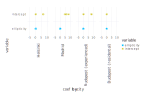

In [215]:
Gadfly.plot(
    to_plot,
    x="coef",
    y="variable",
    color="variable",
    xgroup="city",
    Geom.subplot_grid(Geom.point),
    # xintercept=[0], #Geom.vline([; color="gray80", size=4, style="solid"])
    # Geom.vline(color="gray80", size=4, style="solid")
)

# 4.2 Regressions with interactions into SI

In [38]:
bp1 = lm(
    @formula(gini_multimodal - gini_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0636524    0.00312734    20.35    <1e-87   0.0575211     0.0697837
gini_walk15                         -0.308182     0.00894585   -34.45    <1e-99  -0.32572      -0.290643
area_difference                      0.000840702  0.000388898    2.16    0.0307   7.8246e-5     

In [39]:
bp2 = lm(
    @formula(gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0568917    0.00748433    7.60    <1e-13   0.0422183    0.0715651
gini_walk15                         -0.172091     0.0214092    -8.04    <1e-14  -0.214065    -0.130117
area_difference                     -0.000941519  0.000930709  -1.01    0.3118  -0.00276623   

In [40]:
helsinki1 = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.131641     0.0029063     45.29    <1e-99   0.125942     0.13734
weighted_gini_walk                  -0.390616     0.00814632   -47.95    <1e-99  -0.40659     -0.374642
area_difference                     -0.00027061   0.000148529   -1.82    0.0686  -0.0005

In [41]:
madrid1 = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                        Coef.  Std. Error       t  Pr(>|t|)  Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.75931   0.213352     31.68    <1e-99   6.34105    7.17757
weighted_gini_walk                  -0.183102  0.00481727  -38.01    <1e-99  -0.192546  -0.173659
area_difference                      0.031518  0.0257577     1.22    0.2211  -0.018978   0.082014
ellipticity         

# 4.2 Access

In [42]:
bp1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.83315    0.0797139     98.27    <1e-99   7.67687     7.98944
walk_sum                            -0.885252   0.00562933  -157.26    <1e-99  -0.896288   -0.874215
area_difference                     -0.0541601  0.0105336     -5.14    <1e-06  -0.0748117  -0.0335084
ellipticity                    

In [43]:
helsinki1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.33186     0.15172     41.73    <1e-99   6.03435     6.62937
walk_sum                            -0.74733     0.0104187  -71.73    <1e-99  -0.76776    -0.7269
area_difference                      0.0763983   0.0155365    4.92    <1e-06   0.0459328   0.106864
ellipticity                          

In [44]:
madrid1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.15877     0.0903436    57.10    <1e-99   4.98166     5.33588
walk_sum                            -0.572462    0.00817056  -70.06    <1e-99  -0.58848    -0.556444
area_difference                      0.00628615  0.012578      0.50    0.6173  -0.018372    0.0309443
ellipticity                 

In [45]:
regtable(
    helsinki1a, madrid1a, bp1a,helsinki1, madrid1, bp2, bp1;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    file="$(output)/SI_Reg_4.tex"
)
regtable(
    helsinki1a, madrid1a, bp1a,helsinki1, madrid1, bp2, bp1;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    file="$(output)/SI_Reg_4.txt"
)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                      Helsinki     Madrid     Budapest         Helsinki               Madrid                                          Budapest                                
                                     ---------   ---------   ---------   --------------------   ------------------   -------------------------------------------------------------------------
                                          multimod_sum - walk_sum         weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   -----------------------------------------   -----------------------------------------   -----------------------------
                                           (

# 4.3 Standardized regressions with interactions

In [46]:
to_scale = ["gini_diff", "area_difference", "ellipticity", "distance_betweenness", "access_diff", "walk_sum"];

for i in vcat(["gini_diff_exp"], to_scale[2:end], ["gini_walk15", "gini_diff_house"])
    bp[!, "$(i)_s"] = scale(bp[!, i])
end;
for i in vcat(to_scale, ["weighted_gini_walk"])
    madrid[!, "$(i)_s"] = scale(madrid[!, i])
    helsinki[!, "$(i)_s"] = scale(helsinki[!, i])
end;

In [47]:
helsinki[!, "weighted_gini_walk"]

2560-element Vector{Float64}:
 0.250487
 0.231618
 0.255993
 0.305224
 0.289138
 0.28925
 0.284304
 0.284255
 0.299941
 0.295781
 0.288133
 0.288957
 0.286847
 ⋮
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435
 0.2435

In [48]:
 scalem(helsinki[!, "weighted_gini_walk"])

2560-element Vector{Float64}:
 -3.3180889972444176
 -4.3823369246141874
 -3.007539996868247
 -0.23081681533551907
 -1.1380981847599765
 -1.1317811691330002
 -1.4107450913742892
 -1.4135087857110924
 -0.5287881863829762
 -0.7634201953849495
 -1.1947821196270416
 -1.1483069332285711
 -1.2673149954867837
  ⋮
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004
 -3.7121692489023004

In [49]:
bp1_s = lm(
    @formula(gini_diff_exp_s ~ gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)
# TODO: ellipticity is not scaled, but it seems not need to

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_exp_s ~ 1 + gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.426535    0.0424472  -10.05    <1e-22  -0.509755   -0.343315
gini_walk15_s           -0.627447    0.0177984  -35.25    <1e-99  -0.662342   -0.592552
area_difference_s        0.0420116   0.0147337    2.85    0.0044   0.0131254   0.0708977
ellipticity              0.791934    0.0747538   10.59    <1e-25   0.645376    0.938493
distance_betweenness_s  -0.532179    0.0174563  -30.49    <1e-99  -0.566403   -0.497955
───

In [50]:
bp2_s = lm(
    @formula(gini_diff_house_s ~ gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house_s ~ 1 + gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0316922   0.0483841   0.66    0.5125  -0.0631674   0.126552
gini_walk15_s           -0.1482      0.0202878  -7.30    <1e-12  -0.187975   -0.108424
area_difference_s        0.217369    0.0167944  12.94    <1e-36   0.184443    0.250296
ellipticity             -0.058842    0.0852093  -0.69    0.4899  -0.225899    0.108215
distance_betweenness_s  -0.131162    0.0198979  -6.59    <1e-10  -0.170173   -0.0921511
─────────

In [51]:
helsinki1_s = lm(
    @formula(gini_diff_s ~ weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_s ~ 1 + weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                              Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.00812654   0.0471775   -0.17    0.8633  -0.100637    0.0843836
weighted_gini_walk_s    -0.751644     0.0158549  -47.41    <1e-99  -0.782734   -0.720554
area_difference_s        0.0760801    0.0148147    5.14    <1e-06   0.0470301   0.10513
ellipticity              0.0181403    0.0809913    0.22    0.8228  -0.140675    0.176956
distance_betweenness_s  -0.115767     0.016186    -7.15    <1e-11  -0.147506   -0.

In [52]:
madrid1_s = lm(
    @formula(gini_diff_s ~ weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_s ~ 1 + weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0783355   0.0331863    2.36    0.0183   0.0132764   0.143395
weighted_gini_walk_s    -0.47407     0.0124724  -38.01    <1e-99  -0.498521   -0.449619
area_difference_s       -0.0173815   0.012516    -1.39    0.1650  -0.0419182   0.00715515
ellipticity             -0.168333    0.064204    -2.62    0.0088  -0.2942     -0.0424666
distance_betweenness_s  -0.172254    0.0126184  -13.65    <1e-40  -0.196991   -0.14

In [53]:
bp1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0680808  0.0178202      3.82    0.0001   0.0331434   0.103018
walk_sum_s              -0.962416   0.00626757  -153.55    <1e-99  -0.974704   -0.950128
area_difference_s        0.0740084  0.00600525    12.32    <1e-33   0.0622348   0.085782
ellipticity             -0.126404   0.031423      -4.02    <1e-04  -0.18801    -0.064797
distance_betweenness_s  -0.031701   0.00614819    -5.16    <1e-06  -0.0437549  -0.0196471


In [54]:
helsinki1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.116828   0.0357544   -3.27    0.0011  -0.186939   -0.0467178
walk_sum_s              -0.908723   0.0126578  -71.79    <1e-99  -0.933543   -0.883902
area_difference_s        0.211088   0.0112449   18.77    <1e-73   0.189038    0.233138
ellipticity              0.216109   0.061382     3.52    0.0004   0.0957454   0.336473
distance_betweenness_s  -0.117092   0.0128809   -9.09    <1e-18  -0.14235    -0.0918336
───────────────

In [55]:
madrid1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.0444625  0.026322     -1.69    0.0912  -0.0960648   0.00713968
walk_sum_s              -0.779955   0.0111398   -70.02    <1e-99  -0.801793   -0.758116
area_difference_s        0.177807   0.00987951   18.00    <1e-69   0.158439    0.197175
ellipticity              0.115347   0.0509664     2.26    0.0237   0.0154318   0.215263
distance_betweenness_s  -0.143105   0.0107379   -13.33    <1e-39  -0.164155   -0.122054
────

In [56]:
regtable(
    helsinki1a_s, madrid1a_s, bp1a_s, helsinki1_s, madrid1_s, bp2_s, bp1_s;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff_s" => "Access (standardized)", "gini_diff_s" => "Gini (standardized)", "gini_diff_house_s" => "Residential Gini (standardized)", "gini_diff_exp_s" => "Experienced Gini (standardized)"),
    file="$(output)/SI_Reg_5_s.tex"
)
regtable(
    helsinki1a_s, madrid1a_s, bp1a_s, helsinki1_s, madrid1_s, bp2_s, bp1_s;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff_s" => "Access (standardized)", "gini_diff_s" => "Gini (standardized)", "gini_diff_house_s" => "Residential Gini (standardized)", "gini_diff_exp_s" => "Experienced Gini (standardized)"),
    file="$(output)/SI_Reg_5_s.txt"
)


------------------------------------------------------------------------------------------------------------------------------------------------------
                          Helsinki     Madrid     Budapest    Helsinki     Madrid                                 Budapest                            
                         ---------   ---------   ---------   ---------   ---------   -----------------------------------------------------------------
                               Access (standardized)          Gini (standardized)    Residential Gini (standardized)   Experienced Gini (standardized)
                         ---------------------------------   ---------------------   -------------------------------   -------------------------------
                               (1)         (2)         (3)         (4)         (5)                               (6)                               (7)
---------------------------------------------------------------------------------------------

# 4.4 interplots

In [57]:
bp1i = lm(
    @formula(gini_multimodal - gini_walk15 ~ gini_walk15 + area_difference + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0652489    0.00284948    22.90    <1e-99   0.0596624     0.0708355
gini_walk15                         -0.308566     0.00894105   -34.51    <1e-99  -0.326095     -0.291037
area_difference                      0.000389847  0.00013682     2.85    0.0044   0.000121604   0.000658091
distance_betweenness

In [58]:
bp2i = lm(
    @formula(gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + area_difference + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0386202   0.00684774    5.64    <1e-07   0.0251949    0.0520456
gini_walk15                         -0.167691    0.0214867    -7.80    <1e-14  -0.209817    -0.125566
area_difference                      0.00421834  0.000328799  12.83    <1e-36   0.00357371   0.00486297
distance_betweenness          

In [59]:
helsinki1i = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + area_difference + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.128678     0.00278437    46.21    <1e-99   0.123218      0.134138
weighted_gini_walk                  -0.388929     0.00814945   -47.72    <1e-99  -0.404909     -0.372949
area_difference                      0.000222899  4.34363e-5     5.13    <1e-06   0.000137725   0.000308073
dis

In [60]:
madrid1i = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + area_difference + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.85606    0.208099     32.95    <1e-99   6.4481      7.26403
weighted_gini_walk                  -0.183401   0.00481652  -38.08    <1e-99  -0.192843   -0.173958
area_difference                     -0.0166833  0.0103672    -1.61    0.1076  -0.0370073   0.0036407
distance_betweenness                -0.138

In [61]:
bp1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.48367    0.0734067    101.95    <1e-99   7.33975     7.62759
walk_sum                            -0.884906   0.00570513  -155.11    <1e-99  -0.896091   -0.873721
area_difference                      0.0495607  0.00370256    13.39    <1e-39   0.0423016   0.0568198
distance_betweenness                 0.0515903  0.00649145     

In [62]:
helsinki1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.29043    0.134378     46.81    <1e-99   6.02692     6.55393
walk_sum                            -0.747498   0.0104135   -71.78    <1e-99  -0.767918   -0.727078
area_difference                      0.0851437  0.00453427   18.78    <1e-73   0.0762525   0.0940349
distance_betweenness                -0.0327827  0.0154595    -2.12

In [63]:
madrid1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.01715    0.0888237    56.48    <1e-99   4.84302     5.19128
walk_sum                            -0.573719   0.00821222  -69.86    <1e-99  -0.589818   -0.557619
area_difference                      0.0927186  0.00510738   18.15    <1e-70   0.082706    0.102731
distance_betweenness                -0.0241548  0.0069557    -3.47    

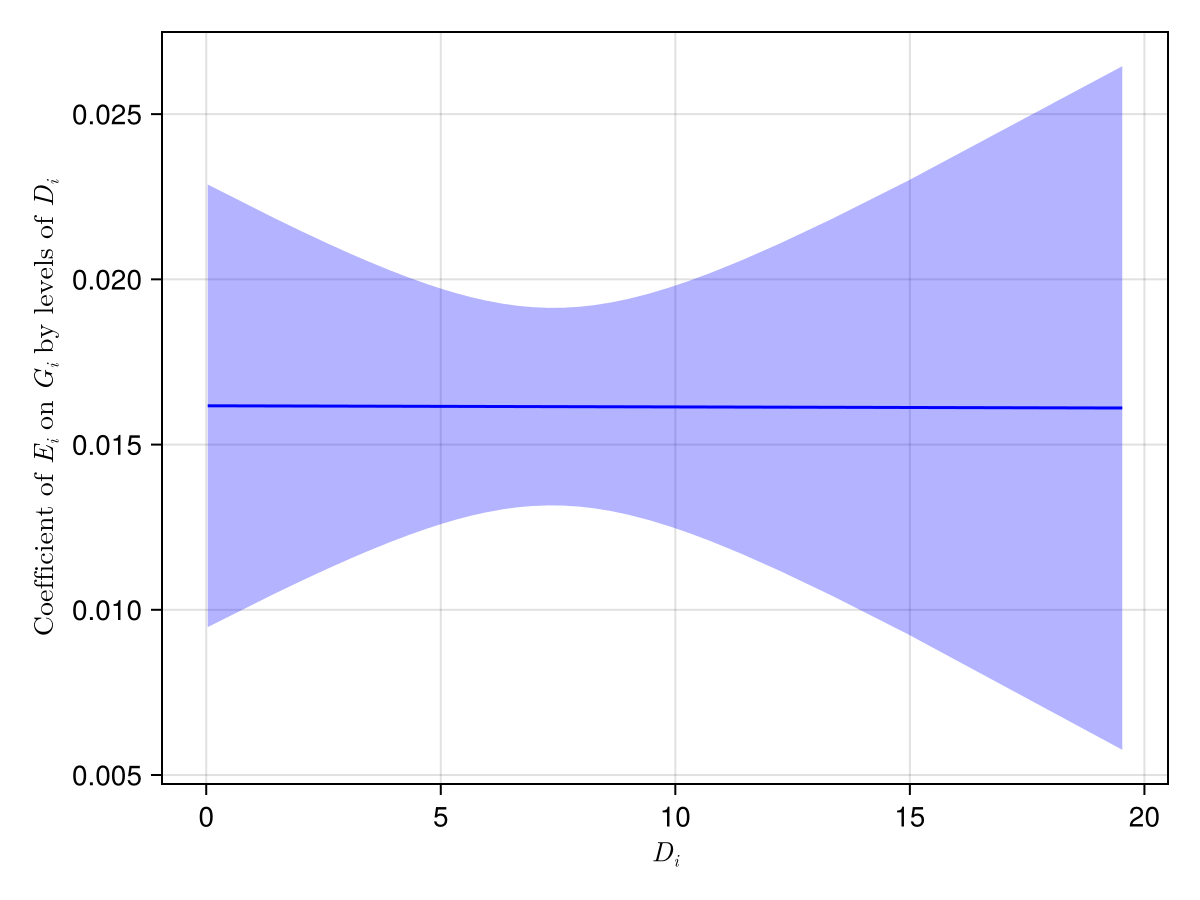

In [64]:
cvals = quantile(bp.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(bp1i, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_bp1.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    # xlabel = "distance_betweenness",
    # ylabel = "Conditional effect of ellipticity",
    # title  = "Conditional Coefficient Plot"
    xlabel = L"$D_i$",
    ylabel = L"Coefficient of $E_i$ on $G_i$ by levels of $D_i$",
)
lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

# hlines!(ax, [0], color=:black, linestyle=:dash)  # zero line for reference
save("$(output)/main_interplot_bp1.png", fig)
fig

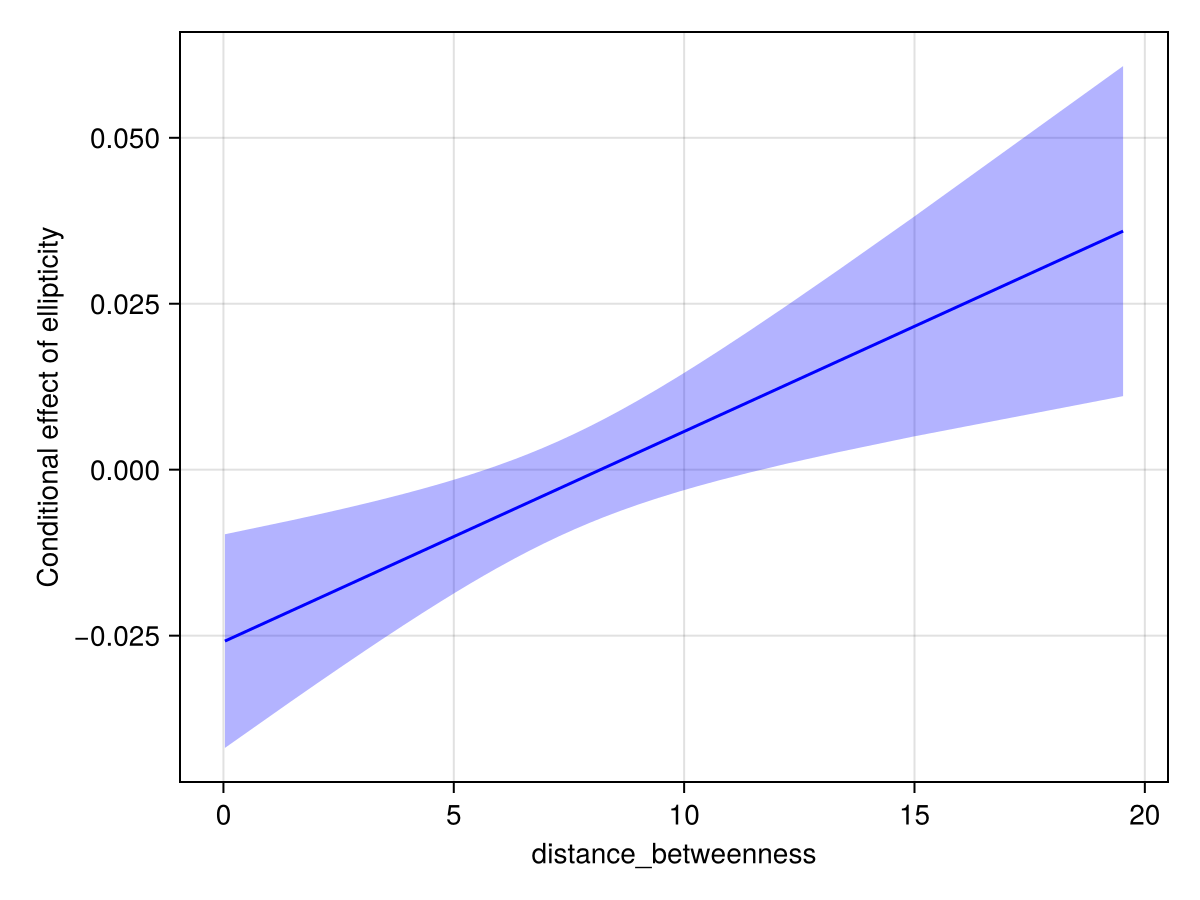

In [65]:
cvals = quantile(bp.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(bp2i, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_bp2.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

# hlines!(ax, [0], color=:black, linestyle=:dash)  # zero line for reference
save("$(output)/main_interplot_bp2.png", fig)
fig

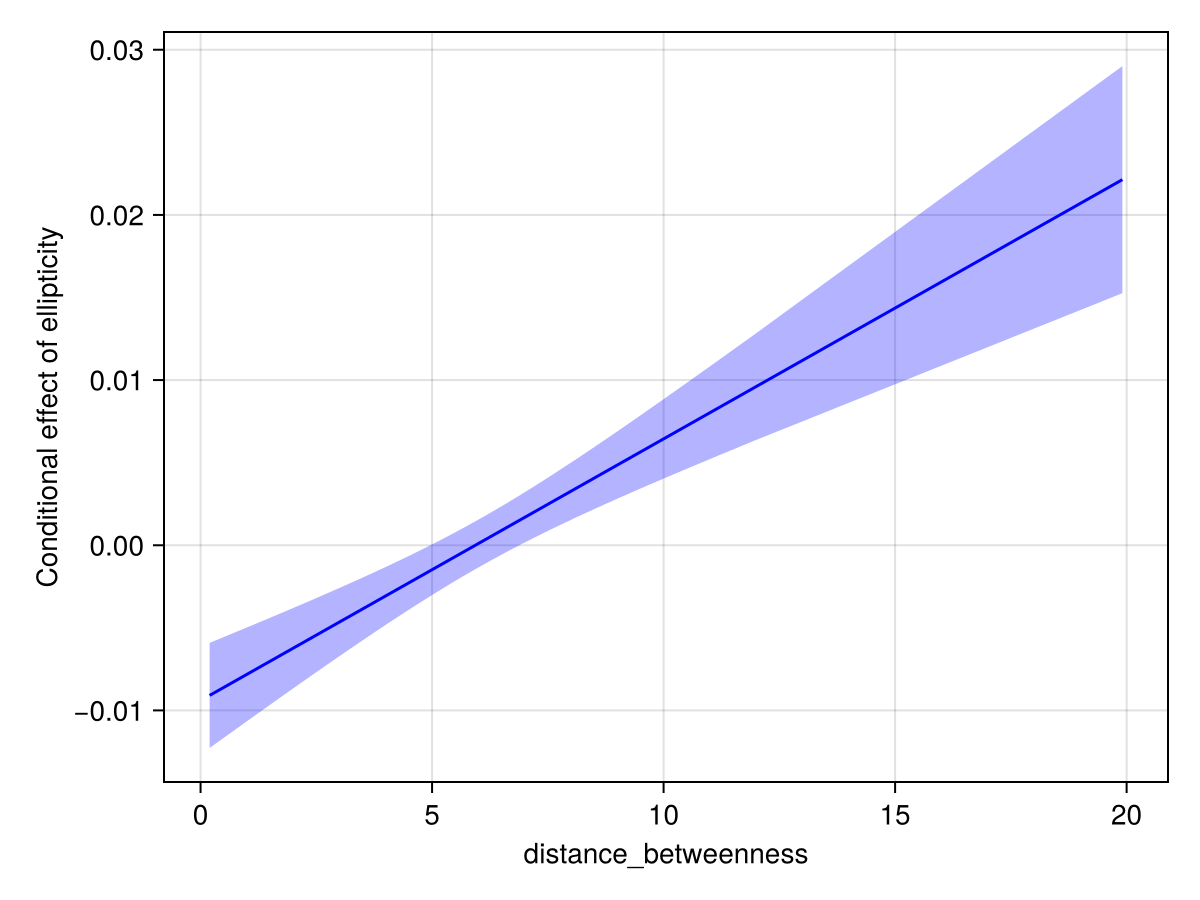

In [66]:
cvals = quantile(helsinki.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(helsinki1i, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_helsinki1.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_helsinki1.png", fig)
fig

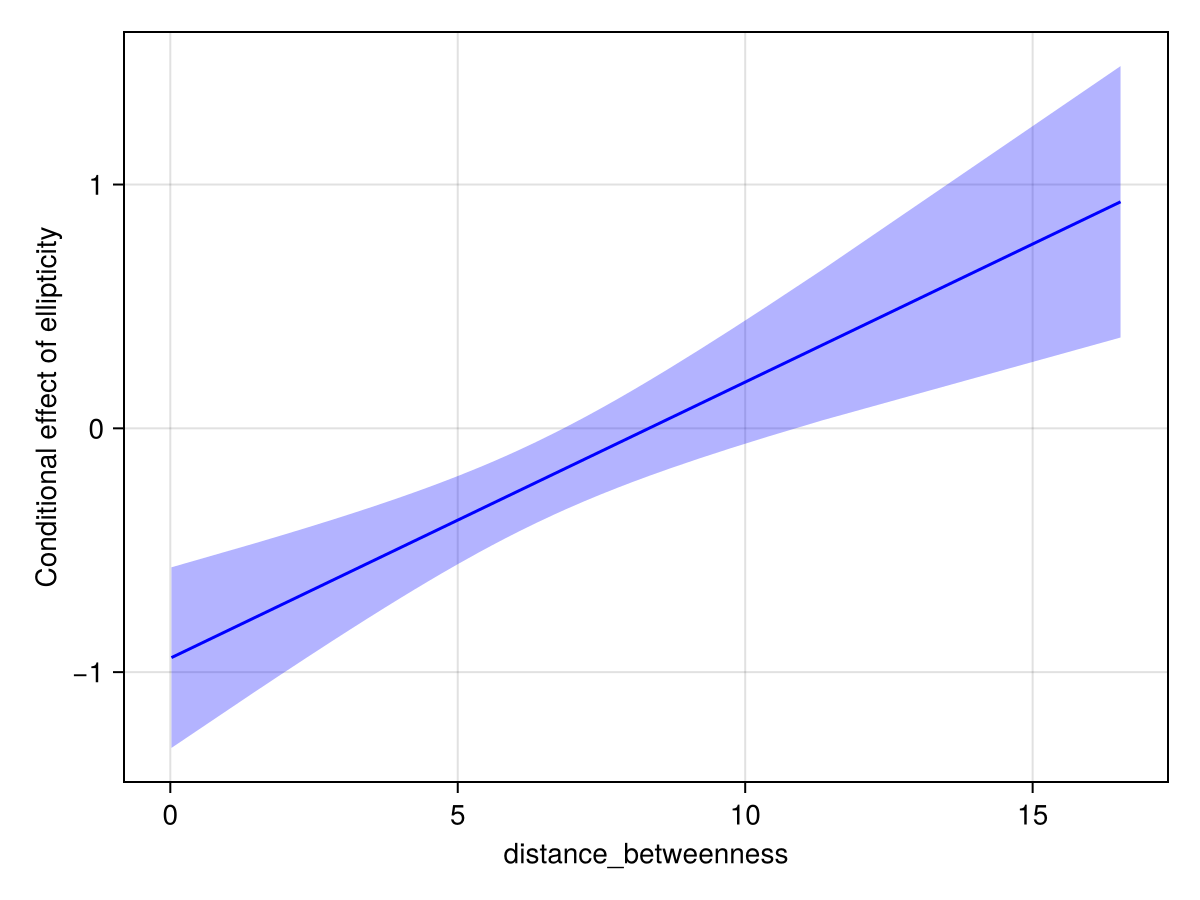

In [67]:
cvals = quantile(madrid.distance_betweenness,0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(madrid1i, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_madrid1.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_madrid1.png", fig)
fig

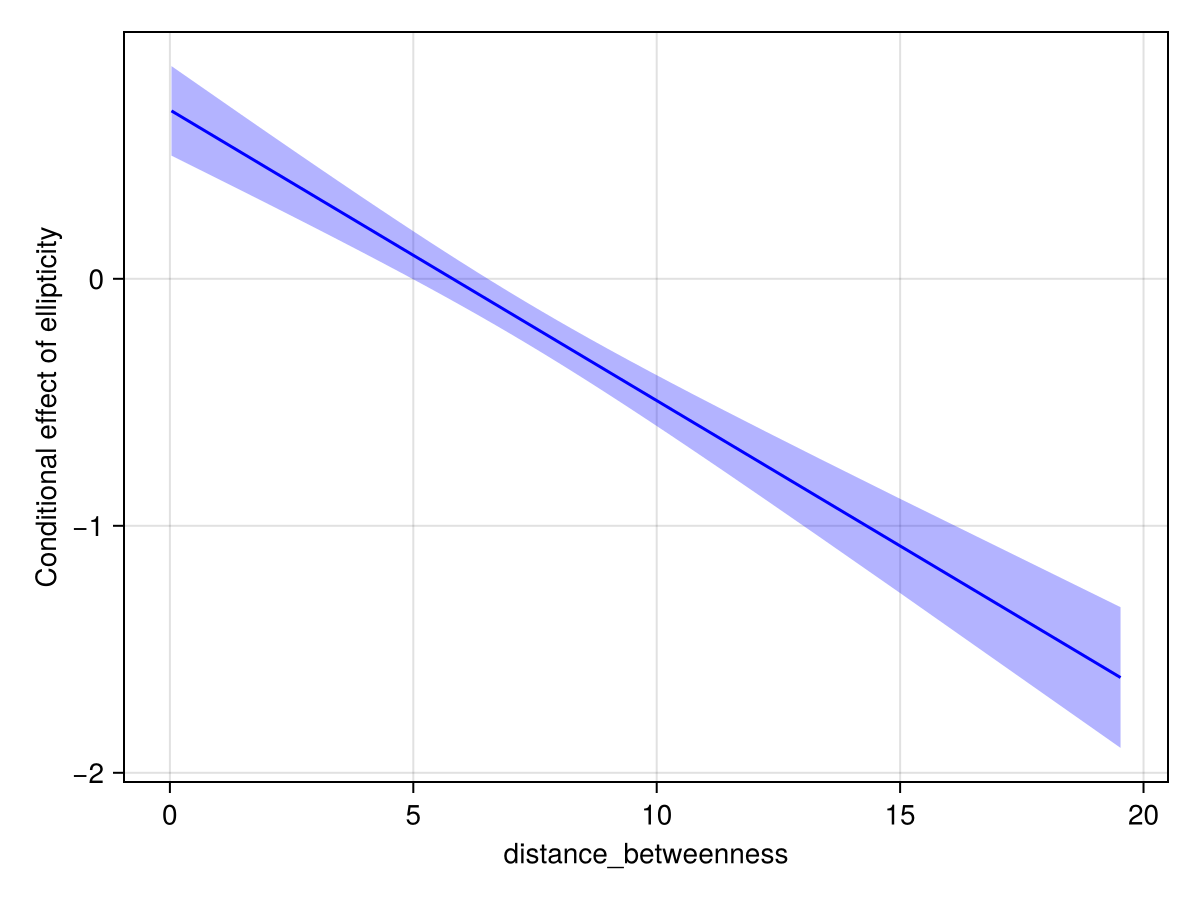

In [68]:
cvals = quantile(bp.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(bp1ai, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_bp1a.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_bp1a.png", fig)
fig

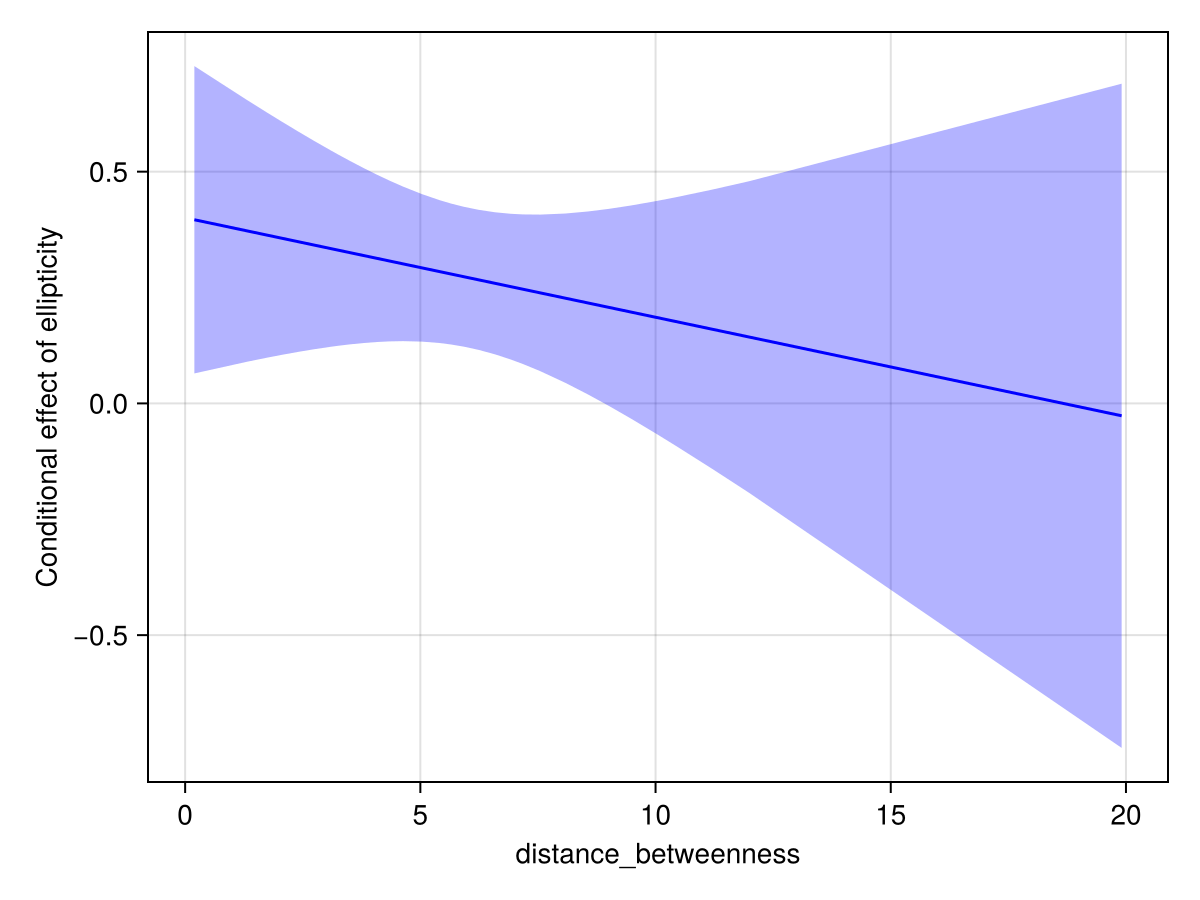

In [69]:
cvals = quantile(helsinki.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(helsinki1ai, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_helsinki1a.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_helsinki1a.png", fig)
fig

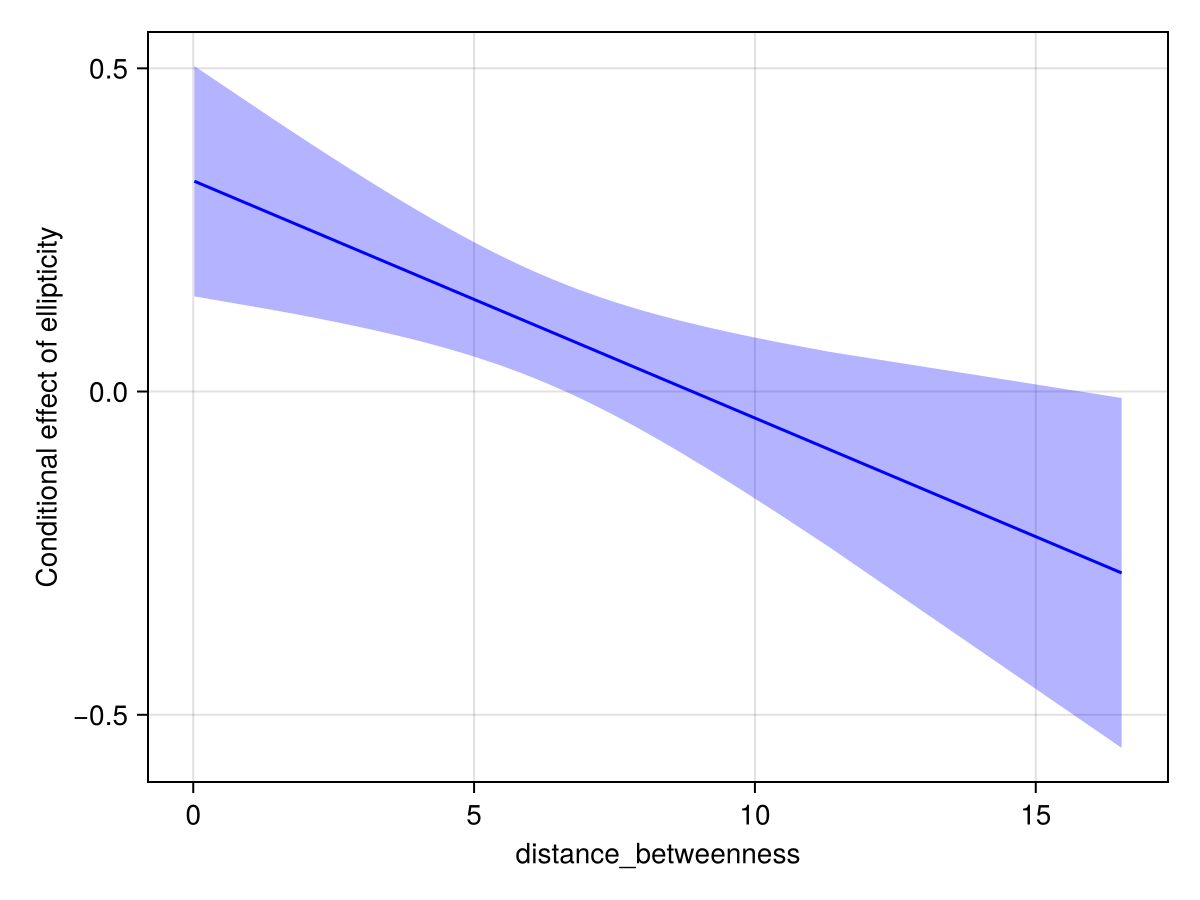

In [70]:
cvals = quantile(madrid.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(madrid1ai, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_madrid1a.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_madrid1a.png", fig)
fig

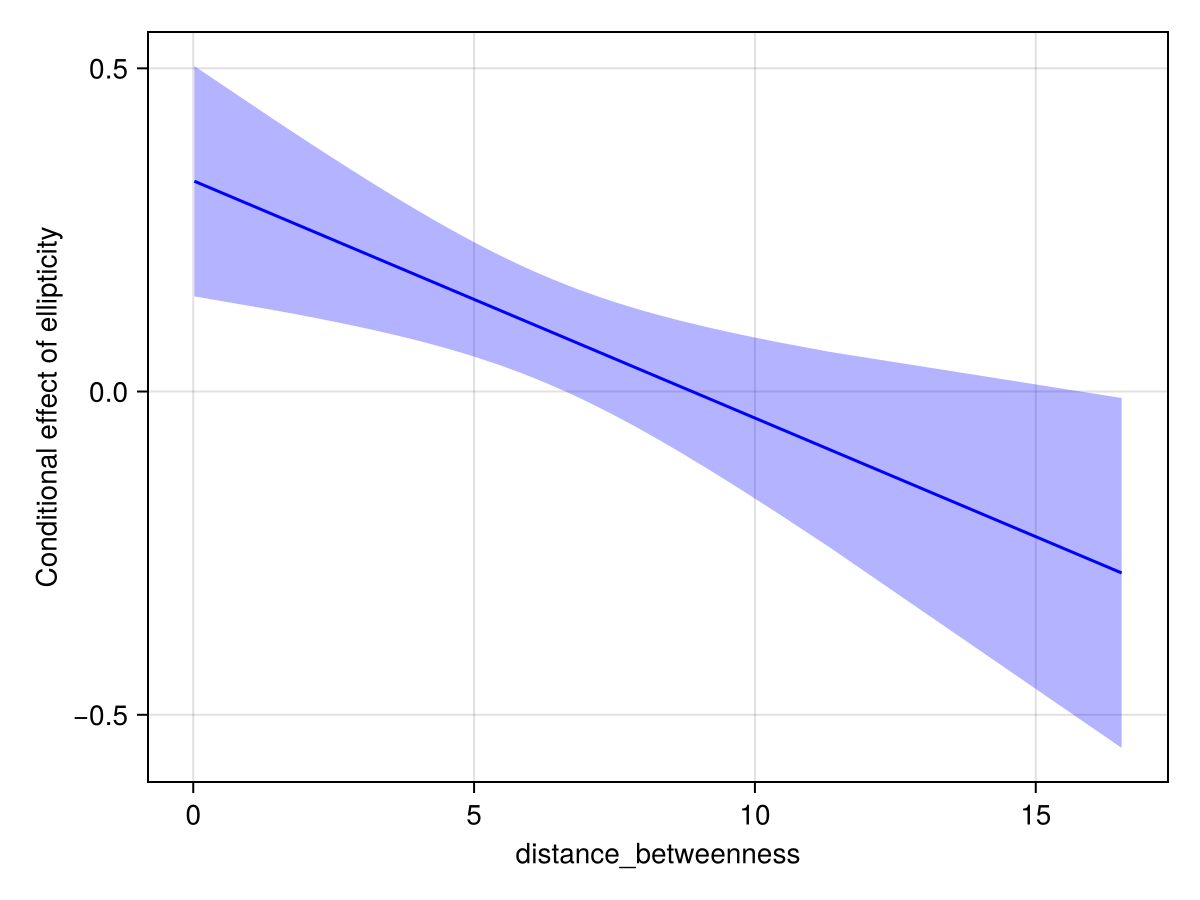

In [71]:
cvals = quantile(madrid.distance_betweenness, 0:1/30:1)  # pick any values you like
res_link = conditional_coef_link(madrid1ai, :ellipticity, :distance_betweenness, cvals)
CSV.write("$(output)/main_interplot_madrid1a.csv", res_link);

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

save("$(output)/main_interplot_madrid1a.png", fig)
fig

# 4.6 Consider socio-economic status of walking area - interactions

In [72]:
bp1_l = lm(@formula(
    gini_multimodal - gini_walk15 ~ gini_walk15 +( area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.arpu_low_ratio_walk15 > median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0665845    0.00428444    15.54    <1e-50   0.0581821     0.074987
gini_walk15                         -0.30648      0.0131918    -23.23    <1e-99  -0.332351     -0.280609
area_difference                      0.00124441   0.000482988    2.58    0.0101   0.000297203   0

In [73]:
bp1_h = lm(@formula(
    gini_multimodal - gini_walk15 ~ gini_walk15 +( area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.arpu_low_ratio_walk15 < median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0788344    0.00483375    16.31    <1e-55   0.0693547     0.0883141
gini_walk15                         -0.643204     0.0185334    -34.71    <1e-99  -0.679551     -0.606858
area_difference                     -0.000707088  0.000622389   -1.14    0.2561  -0.00192768    

In [74]:
bp2_l = lm(@formula(
    gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.  Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0472158    0.0135992    3.47    0.0005   0.0205458    0.0738858
gini_walk15                         -0.175715     0.0547964   -3.21    0.0014  -0.283179    -0.0682508
area_difference                     -0.00309822   0.00145283  -2.13    0.0331  -0.00594745  -0.000

In [75]:
bp2_h = lm(@formula(
    gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.  Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0395653    0.0105383    3.75    0.0002   0.0188982    0.0602325
gini_walk15                         -0.146031     0.0302031   -4.83    <1e-05  -0.205263    -0.0867979
area_difference                      0.000872505  0.00125985   0.69    0.4887  -0.00159824   0.003

In [76]:
helsinki1_l = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.138612     0.00459549    30.16    <1e-99   0.129596      0.147627
weighted_gini_walk                  -0.425719     0.0135539    -31.41    <1e-99  -0.452309     -0.399129
area_difference                     -0.000176793  0.000120144   -1.47    0.1414

In [77]:
helsinki1_h = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.14376      0.0043961     32.70    <1e-99   0.135136      0.152385
weighted_gini_walk                  -0.410962     0.012587     -32.65    <1e-99  -0.435655     -0.386268
area_difference                     -0.000301506  0.000266717   -1.13    0.2585

In [78]:
madrid1_l = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.1958     0.314269     19.71    <1e-80   5.57956     6.81205
weighted_gini_walk                  -0.194609   0.00872147  -22.31    <1e-99  -0.211711   -0.177508
area_difference                      0.0651708  0.0208612     3.12    0.0018   0.0242645   0.106077
ellipticity

In [79]:
madrid1_h = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)  Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          8.93477    0.349145     25.59    <1e-99   8.25014    9.6194
weighted_gini_walk                  -0.230729   0.00751027  -30.72    <1e-99  -0.245456  -0.216002
area_difference                     -0.0148265  0.0520717    -0.28    0.7759  -0.116933   0.0872796
ellipticity   

In [80]:
bp1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          8.20335     0.168993     48.54    <1e-99   7.87193     8.53477
walk_sum                            -0.900903    0.0076109  -118.37    <1e-99  -0.915829   -0.885977
area_difference                     -0.120308    0.0189438    -6.35    <1e-09  -0.15746    -0.0831565
ellipticity                    

In [81]:
bp1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.39885     0.101438     72.94    <1e-99   7.19992     7.59779
walk_sum                            -0.849224    0.00849313  -99.99    <1e-99  -0.865881   -0.832568
area_difference                      0.00725207  0.0112792     0.64    0.5203  -0.0148681   0.0293722
ellipticity                    

In [82]:
helsinki1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.51597     0.177196    36.77    <1e-99   6.16835     6.8636
walk_sum                            -0.815966    0.0139876  -58.34    <1e-99  -0.843407   -0.788525
area_difference                      0.139125    0.0179125    7.77    <1e-13   0.103984    0.174266
ellipticity                         

In [83]:
helsinki1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.01906      0.271559    25.85    <1e-99   6.4863      7.55181
walk_sum                            -0.761204     0.0160354  -47.47    <1e-99  -0.792663   -0.729746
area_difference                      0.0152357    0.0249544    0.61    0.5416  -0.0337206   0.064192
ellipticity                     

In [84]:
madrid1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          4.43372      0.13144     33.73    <1e-99   4.17598     4.69146
walk_sum                            -0.515815     0.0111891  -46.10    <1e-99  -0.537755   -0.493875
area_difference                      0.00775929   0.0157417    0.49    0.6221  -0.0231082   0.0386268
ellipticity                    

In [85]:
madrid1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.89997    0.129336     45.62    <1e-99   5.64636     6.15358
walk_sum                            -0.64417    0.0118307   -54.45    <1e-99  -0.667368   -0.620971
area_difference                     -0.0213257  0.0209101    -1.02    0.3079  -0.0623278   0.0196763
ellipticity                       

In [86]:
regtable(
    helsinki1a_l, madrid1a_l, bp1a_l, helsinki1_l, madrid1_l, bp2_l, bp1_l,;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest (property price)", "Budapest (subscriber info)"],
    file="$(output)/SI_Reg_6_low.tex"
)
regtable(
    helsinki1a_l, madrid1a_l, bp1a_l, helsinki1_l, madrid1_l, bp2_l, bp1_l,;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest (property price)", "Budapest (subscriber info)"],
    file="$(output)/SI_Reg_6_low.txt"
)



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                      Helsinki     Madrid     Budapest         Helsinki               Madrid                 Budapest (property price)             Budapest (subscriber info) 
                                     ---------   ---------   ---------   --------------------   ------------------   -----------------------------------------   -----------------------------
                                          multimod_sum - walk_sum         weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   -----------------------------------------   -----------------------------------------   -----------------------------
                                           (

In [87]:
regtable(
    helsinki1a_h, madrid1a_h, bp1a_h, helsinki1_h, madrid1_h, bp2_h, bp1_h;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest (property price)", "Budapest (subscriber info)"],
    file="$(output)/SI_Reg_7_high.tex"
)
regtable(
    helsinki1a_h, madrid1a_h, bp1a_h, helsinki1_h, madrid1_h, bp2_h, bp1_h;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest (property price)", "Budapest (subscriber info)"],
    file="$(output)/SI_Reg_7_high.txt"
)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                      Helsinki     Madrid     Budapest         Helsinki               Madrid                 Budapest (property price)             Budapest (subscriber info) 
                                     ---------   ---------   ---------   --------------------   ------------------   -----------------------------------------   -----------------------------
                                          multimod_sum - walk_sum         weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   -----------------------------------------   -----------------------------------------   -----------------------------
                                           (

# 4.7 Correlation plots

In [88]:
vars_bp = ["access_diff","gini_diff_exp", "gini_diff_house", "walk_sum", "gini_walk15", "area_difference", "ellipticity", "distance_betweenness"];
vars_he = ["access_diff","gini_diff", "walk_sum","weighted_gini_walk", "area_difference", "ellipticity", "distance_betweenness"];
vars_ma = ["access_diff","gini_diff", "walk_sum","weighted_gini_walk", "area_difference", "ellipticity", "distance_betweenness"];

In [89]:
corr_mx_bp = cor(Matrix(bp[:,vars_bp]))

8×8 Matrix{Float64}:
  1.0         0.149881    0.0771804  …  -0.0774002   0.170618    0.355281
  0.149881    1.0         0.0343778     -0.0997761   0.156745   -0.117255
  0.0771804   0.0343778   1.0            0.201543   -0.0854068  -0.0656279
 -0.930884   -0.105403   -0.0524908      0.170447   -0.234966   -0.415268
 -0.338134   -0.303432   -0.0104895      0.243062   -0.153143   -0.633801
 -0.0774002  -0.0997761   0.201543   …   1.0        -0.356724   -0.122969
  0.170618    0.156745   -0.0854068     -0.356724    1.0         0.146108
  0.355281   -0.117255   -0.0656279     -0.122969    0.146108    1.0

In [90]:
CSV.write("$(output)/bud_for_corrplot.csv", bp[:, vars_bp]);
CSV.write("$(output)/hel_for_corrplot.csv", helsinki[:, vars_he]);
CSV.write("$(output)/mad_for_corrplot.csv", madrid[:, vars_ma]);

# 4.8 Variable Statistics

In [91]:
# Subset and drop missing data
bp_sub = dropmissing(bp[:, vars_bp])
helsinki_sub = dropmissing(helsinki[:, vars_he])
madrid_sub = dropmissing(madrid[:, vars_ma])
;

In [92]:
bud_sum = describe(bp_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_bp.csv", bud_sum);
hel_sum = describe(helsinki_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_helsinki.csv", hel_sum);
mad_sum = describe(madrid_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_madrid.csv", mad_sum);

In [93]:
open("$(output)/SI_summary_bp.tex", "w") do io
    pretty_table(io, bud_sum, backend = Val(:latex); show_subheader=false, label = "tab:budapest_stats", title = "Summary Statistics for Budapest", wrap_table = true)
end
open("$(output)/SI_summary_helsinki.tex", "w") do io
    pretty_table(io, hel_sum, backend = Val(:latex); show_subheader=false, label = "tab:helsinki_stats", title = "Summary Statistics for Helsinki", wrap_table = true)
end
open("$(output)/SI_summary_madrid.tex", "w") do io
    pretty_table(io, mad_sum, backend = Val(:latex); show_subheader=false, label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true)
end
;